<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=1*365)            # 1 year before the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2024-05-30 to 2025-05-30
Time span: 365 days (1.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042300000000000004 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-30.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 998 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 1000 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 999 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 996 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 1000 articles fetched
Fetching page 12/15...
Page 12: 1000 articles fetched
Fetching page 13/15...
Page 13: 998 articles fetched
Fetching page 14/15...
Page 14: 999 articles fetched
Fetching page 15/15...
Page 15: 1000 articles fetched
Total articles fetched: 14990


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""LULU""","""2025-06-02 14:34:30""","""Best of June: Retail Stock Cou…","""https://images.financialmodeli…","""schaeffersresearch.com""","""Lululemon Athletica Inc (NASD…","""https://www.schaeffersresearch…"
"""SEZL""","""2025-06-02 14:34:08""","""Why Sezzle Stands Out: A Compe…","""https://images.financialmodeli…","""seekingalpha.com""","""Sezzle is a high-growth BNPL p…","""https://seekingalpha.com/artic…"
"""WTI""","""2025-06-02 14:32:30""","""Natural Gas, WTI Oil, Brent Oi…",null,"""fxempire.com""","""OPEC+ will boost production by…","""https://www.fxempire.com/forec…"
"""HYMTF""","""2025-06-02 14:32:00""","""Hyundai America Technical Cent…","""https://images.financialmodeli…","""prnewswire.com""","""SUPERIOR TOWNSHIP, Mich., June…","""https://www.prnewswire.com/new…"
"""SNDK""","""2025-06-02 14:31:27""","""SanDisk Corporation: The Techn…","""https://images.financialmodeli…","""seekingalpha.com""","""Sandisk Corporation posted a s…","""https://seekingalpha.com/artic…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

# Export results
# sentiment_with_fundamentals.write_csv("data/combined_sentiment_fundamentals.csv")
# comprehensive_screened.write_csv("data/screened_stocks.csv")
# print("Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv")

Loading fundamental data...
Loaded 504 stocks, 4215 unique tickers
Analyzing sentiment for stock symbols...

Screened 1672 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CAE""",4,0.8,0.0,1.0,0.6,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""NSCIF""",3,0.7803,0.0,1.0,0.5606,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""HBFG""",5,0.7788,0.0,1.0,0.5576,5,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.4999,0.5667,"""Consumer Cyclical""",1.4031e10,16.17,66.28


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",28,0.589368,0.582493,17.071429,4.2542e10,21.169643
"""Communication Services""",19,0.581942,0.586816,27.368421,3.9771e11,NaN
"""Healthcare""",52,0.572198,0.524896,20.365385,8.9752e10,NaN
"""Technology""",77,0.5717,0.527221,17.077922,2.1666e11,NaN
"""Consumer Defensive""",32,0.567297,0.536269,15.1875,1.0240e11,NaN
…,…,…,…,…,…,…
"""Industrials""",62,0.561363,0.469887,10.387097,5.9014e10,NaN
"""Energy""",21,0.558457,0.385605,6.380952,7.0332e10,NaN
"""Real Estate""",28,0.557882,0.424143,8.75,3.6466e10,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['PH', 'TMUS', 'MMC', 'MS', 'SO']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.4999,0.5667,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""CHTR""",5,0.71,0.0,0.8,0.42,5,0.5868,0.5819,"""Communication Services""",5.4738e10,11.06,396.27
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.5272,0.5717,"""Technology""",4.8285e10,20.84,191.13
"""ZTS""",5,0.6844,0.0,1.0,0.3689,5,0.5249,0.5722,"""Healthcare""",7.5075e10,30.33,168.63
"""FI""",6,0.67,0.0,0.6667,0.3401,6,0.5272,0.5717,"""Technology""",9.0256e10,28.81,162.79



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",22,0.247718,0.62385,0.717186
"""Industrials""",17,0.233229,0.616612,0.742729
"""Utilities""",13,0.246808,0.6234,0.6792
"""Consumer Cyclical""",13,0.255462,0.627723,0.734054
"""Healthcare""",10,0.23431,0.61715,0.73591



Summary statistics for selected stocks:
Average sentiment score: 0.2431
Min sentiment score: 0.1747
Max sentiment score: 0.5571
Average company news score: 0.6215
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import suppress_output

quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
display(quotes.tail())

,bby,chtr,nxpi,zts,fi,ual,ato,lrcx,fis,peg,...,fe,fico,ceg,bmy,oxy,khc,dal,tsco,amat,cl
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-23,69.919998,406.359985,192.149994,162.580002,159.339996,74.650002,156.410004,81.059998,78.220001,78.959999,...,42.110001,1694.359985,297.489990,46.849998,41.290001,25.910658,47.919998,49.473106,157.509995,92.589996
2025-05-27,72.220001,411.130005,198.899994,166.259995,160.139999,78.180000,156.490005,83.940002,79.959999,79.599998,...,42.099998,1503.619995,309.059998,46.889999,41.619999,26.432814,49.400002,50.150002,161.830002,92.430000
2025-05-28,71.519997,407.380005,196.210007,165.399994,160.740005,77.500000,153.720001,84.000000,79.970001,78.089996,...,41.189999,1619.939941,308.049988,46.970001,41.119999,26.147108,48.599998,49.060001,161.589996,91.760002
2025-05-29,66.320000,395.809998,195.889999,167.139999,159.619995,78.570000,154.339996,84.160004,78.269997,79.550003,...,41.700001,1685.000000,303.369995,47.849998,41.459999,26.620001,48.500000,48.970001,159.479996,92.300003
2025-05-30,66.279999,396.269989,191.130005,168.630005,162.789993,79.440002,154.679993,80.790001,79.610001,81.029999,...,41.939999,1726.280029,306.149994,48.279999,40.779999,26.730000,48.389999,48.400002,156.750000,92.940002


### Step 7: Create Trading Signals
- Use `talib` library to create signals.

In [10]:
from py.technical_analysis import calculate_technical_indicators, generate_trading_signals

# Execute technical analysis
technical_indicators = calculate_technical_indicators(quotes)
trading_signals = generate_trading_signals(technical_indicators)
available_tickers = list(technical_indicators.keys())

# Display sample results for first ticker
sample_ticker = available_tickers[0]
print(f"\nSample indicators and signals for {sample_ticker}:")
display(technical_indicators[sample_ticker].tail())

✅ Technical indicators calculated for 100 tickers
✅ Trading signals generated for 100 tickers

Sample indicators and signals for bby:


,Close,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,ADX,PLUS_DI,MINUS_DI,RSI_14,RSI_21
Date,,,,,,,,,,,,
2025-05-23,69.919998,69.8850,68.353316,82.888460,70.671606,69.689109,70.661822,13.754470,50.782719,49.217281,50.782719,49.738551
2025-05-27,72.220001,70.1220,68.385867,82.859095,70.909820,69.876582,70.722928,13.779281,57.050909,42.949091,57.050909,53.703091
2025-05-28,71.519997,70.3640,68.359390,82.817231,71.003694,69.998316,70.754185,13.475742,54.764869,45.235131,54.764869,52.382686
2025-05-29,66.320000,70.3455,68.241552,82.743705,70.283125,69.725849,70.580296,13.731621,41.470973,58.529027,41.470973,43.953380
2025-05-30,66.279999,70.3075,68.109880,82.682221,69.667260,69.470600,70.411656,13.981114,41.387744,58.612256,41.387744,43.896326


### Step 8: Backtest Strategies and Select Top 10 Stocks ***(by CAGR & Volatility)***
- Use `bt` library for backtesting the strategy.

In [11]:
from py.technical_analysis import run_backtest, best_strategy_analysis

# Configuration constants
PORTFOLIO_CONFIG = {
    'max_volatility': 0.3,  # Maximum 30% volatility
    'max_stocks': 10        # Maximum 10 stocks in portfolio
}

# Step 1: Run strategy backtesting
backtest_data = run_backtest(quotes, trading_signals, available_tickers)

# Step 2: Analyze best strategies and build portfolio
analysis_results = best_strategy_analysis(quotes, trading_signals, backtest_data, available_tickers, **PORTFOLIO_CONFIG)

# Step 3: Display results
selected_tickers = analysis_results['selected_tickers']
best_strategies_df = analysis_results['best_strategies_df']
print(f"\n📊 Best Strategies for {len(selected_tickers)} Selected Tickers:")
display(best_strategies_df.sort_values('cagr', ascending=False))

STRATEGY BACKTESTING ANALYSIS

🔄 Running strategy backtests...
🔄 Running 400 backtests silently...
  Progress: 5%
  Progress: 10%
  Progress: 15%
  Progress: 20%
  Progress: 25%
  Progress: 30%
  Progress: 35%
  Progress: 40%
  Progress: 45%
  Progress: 50%
  Progress: 55%
  Progress: 60%
  Progress: 65%
  Progress: 70%
  Progress: 75%
  Progress: 80%
  Progress: 85%
  Progress: 90%
  Progress: 95%
  Progress: 100%
✅ Backtesting completed

🔄 Portfolio Construction
📊 CAGR Filtering: 100 → 94 tickers (≥0.0%)
📊 Volatility Filtering: → 73 tickers (≤30.0%)
🏆 Selected top 10 performers:
  #1. cnp: 44.60% CAGR, 19.97% Vol, Sharpe: 1.96 (EMA_Cross_Signal)
  #2. gild: 42.95% CAGR, 25.17% Vol, Sharpe: 1.55 (EMA_Cross_Signal)
  #3. nvr: 37.11% CAGR, 23.07% Vol, Sharpe: 1.49 (SMA_Cross_Signal)
  #4. pm: 36.10% CAGR, 24.98% Vol, Sharpe: 1.37 (EMA_Cross_Signal)
  #5. fis: 35.83% CAGR, 25.11% Vol, Sharpe: 1.35 (SMA_Cross_Signal)
  #6. anet: 30.60% CAGR, 26.56% Vol, Sharpe: 1.13 (RSI_Signal)
  #7. lmt

,cagr,total_return,max_drawdown,sharpe_ratio,volatility,strategy
cnp,0.445980,0.447076,-0.086500,1.958107,0.199694,EMA_Cross_Signal
gild,0.429499,0.430548,-0.178775,1.554255,0.251708,EMA_Cross_Signal
nvr,0.371052,0.371941,-0.103269,1.492007,0.230705,SMA_Cross_Signal
pm,0.361047,0.361908,-0.234092,1.367343,0.249787,EMA_Cross_Signal
fis,0.358282,0.359136,-0.119635,1.349908,0.251136,SMA_Cross_Signal
anet,0.306015,0.306731,-0.096810,1.132834,0.265629,RSI_Signal
lmt,0.295949,0.296639,-0.132242,1.295686,0.219787,SMA_Cross_Signal
fcx,0.287298,0.287966,-0.058374,1.472064,0.183269,RSI_Signal
csco,0.275575,0.276213,-0.191925,1.246661,0.215092,SMA_Cross_Signal
lrcx,0.274488,0.275123,-0.093986,1.166438,0.230613,RSI_Signal


### Step 9: Plot Results

📊 Generating Portfolio Charts...

📈 Portfolio Performance:


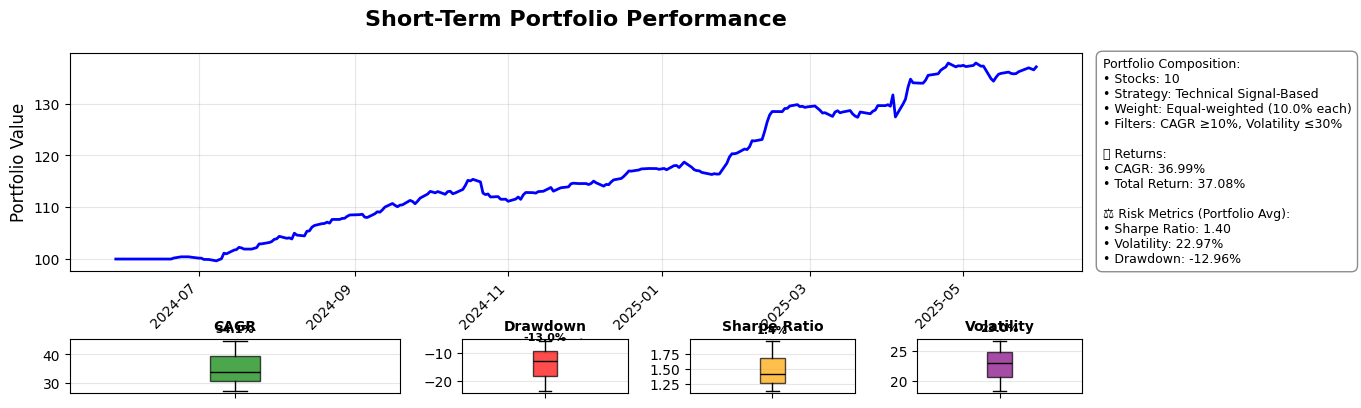


📈 Strategy Signals by Ticker:
📋 Included tickers: ['cnp', 'gild', 'nvr', 'pm', 'fis', 'anet', 'lmt', 'fcx', 'csco', 'lrcx']
📊 Plotting 10 tickers that passed the 10% CAGR and ≤30% volatility thresholds


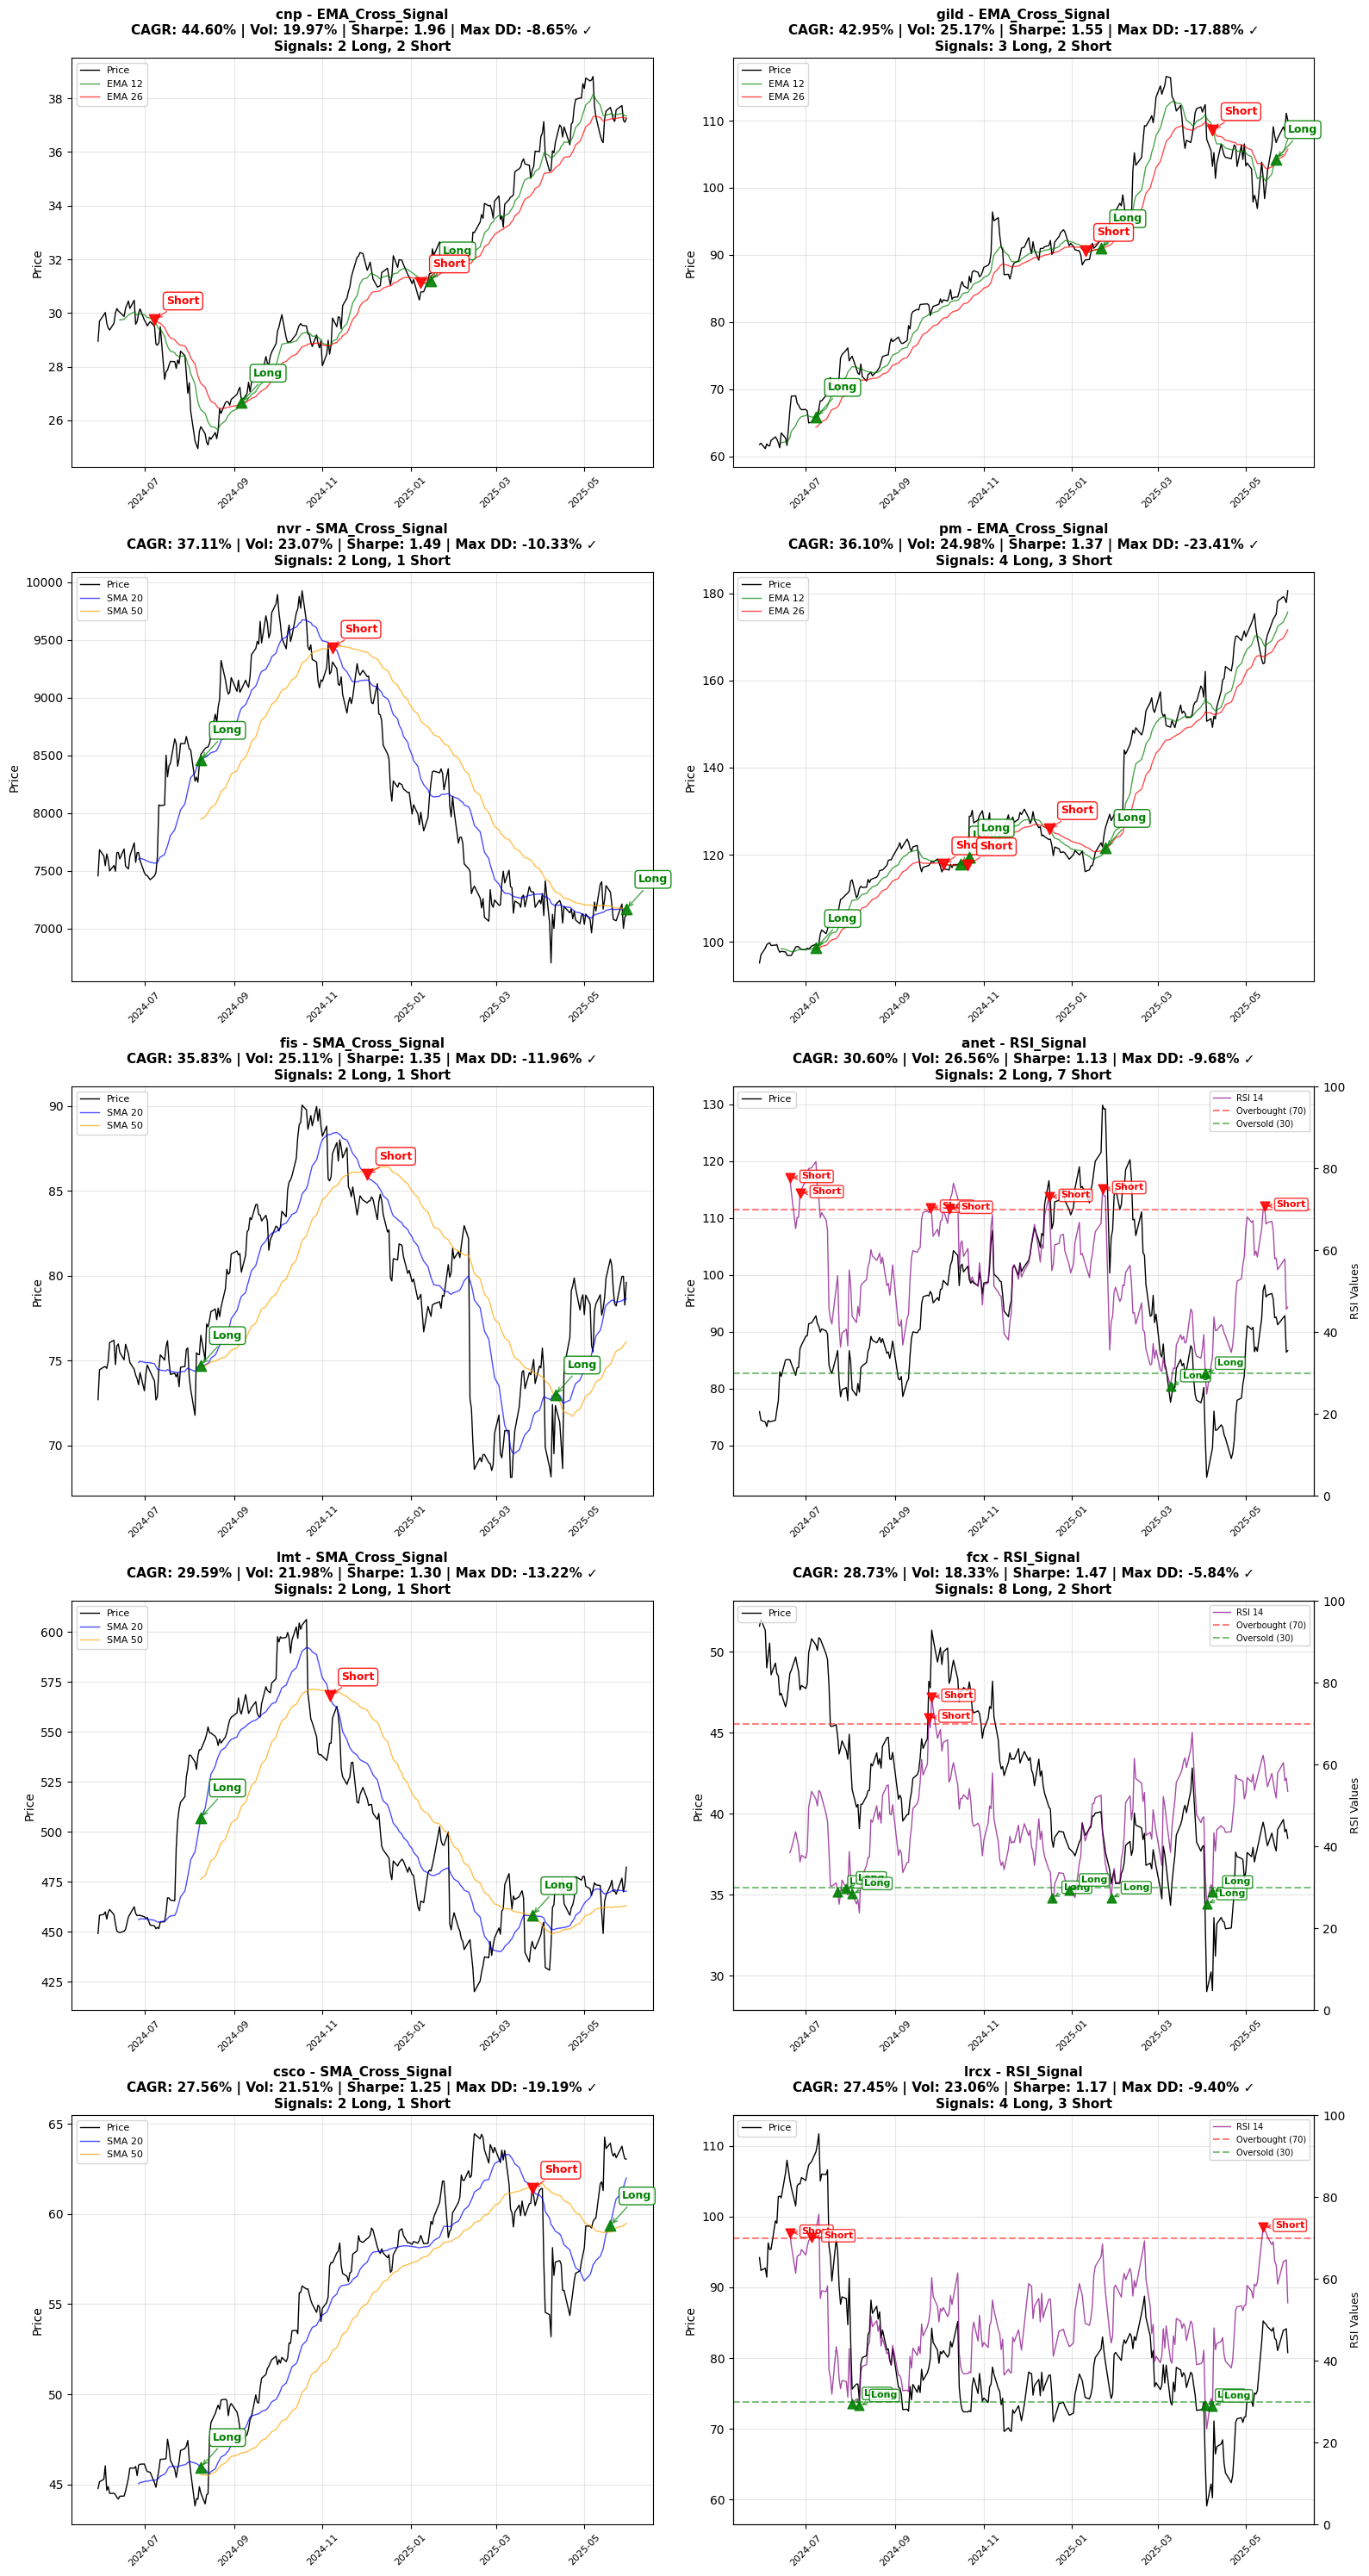


✅ Chart generation complete!


In [12]:
from py.technical_analysis import plot_portfolio_performance, plot_ticker_signals_with_annotations

# Chart generation
print("📊 Generating Portfolio Charts...")

for chart_type, func in [("Portfolio Performance", lambda: plot_portfolio_performance(analysis_results)), 
                         ("Strategy Signals by Ticker", lambda: plot_ticker_signals_with_annotations(
                             quotes, trading_signals, technical_indicators, 
                             analysis_results['best_strategies'], analysis_results['included_tickers'])
                          if all([quotes is not None, trading_signals, technical_indicators,
                                 all(key in analysis_results for key in ['best_strategies', 'included_tickers']),
                                 analysis_results['included_tickers']]) 
                          else print("⚠️ Missing required data or no tickers passed thresholds"))]:
    try:
        print(f"\n📈 {chart_type}:")
        if chart_type == "Strategy Signals by Ticker" and analysis_results.get('included_tickers'):
            print(f"📋 Included tickers: {analysis_results['included_tickers']}")
        func()
    except Exception as e:
        print(f"Error plotting {chart_type.lower()}: {e}")

print("\n✅ Chart generation complete!")

### Step 10: Merge Strategy with Fundamental + Sentiment Analysis Data

In [13]:
from py.utils import clean_column_names

print("Selected tickers from analysis_results:")
print(analysis_results['selected_tickers'])

# Create a DataFrame with tickers and merge with best_strategies_df
best_strategies_with_tickers = best_strategies_df.copy()
best_strategies_with_tickers['Ticker'] = [ticker.upper() for ticker in analysis_results['selected_tickers']] # Convert tickers to uppercase to match fundamentals_df format

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(best_strategies_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
    # Add other columns you want to keep, but exclude 'sector' to avoid duplication
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')  # Remove the original lowercase symbol column

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas if needed for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)
display(short_term_portfolio_df)

Selected tickers from analysis_results:
['cnp', 'gild', 'nvr', 'pm', 'fis', 'anet', 'lmt', 'fcx', 'csco', 'lrcx']


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Sharpe Ratio,Volatility,Strategy,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score
Ticker,,,,,,,,,,,,,,,,,,,,,
ANET,2025-06-02,Arista Networks Inc,Technology,Computer Hardware,United States,https://www.arista.com,1.088129e+11,1.006634e+11,1.029429e+09,1.255920e+09,...,1.132834,0.265629,RSI_Signal,9,0.6145,0.0000,0.7778,0.2290,0.5272,0.5717
CNP,2025-06-02,"CenterPoint Energy, Inc.",Utilities,Utilities - Regulated Electric,United States,https://www.centerpointenergy.com,2.430759e+10,4.457861e+10,6.493864e+08,6.527280e+08,...,1.958107,0.199694,EMA_Cross_Signal,7,0.6101,0.0000,0.5714,0.2203,0.5825,0.5894
CSCO,2025-06-02,"Cisco Systems, Inc.",Technology,Communication Equipment,United States,https://www.cisco.com,2.496384e+11,2.639913e+11,3.954019e+09,3.960000e+09,...,1.246661,0.215092,SMA_Cross_Signal,3,0.6139,0.0000,1.0000,0.2278,0.5272,0.5717
FCX,2025-06-02,Freeport-McMoRan Inc.,Basic Materials,Copper,United States,https://fcx.com,5.526497e+10,7.180998e+10,1.427325e+09,1.436200e+09,...,1.472064,0.183269,RSI_Signal,4,0.6064,0.0000,0.5000,0.2129,0.4346,0.5449
FIS,2025-06-02,"Fidelity National Information Services, Inc.",Technology,Information Technology Services,United States,https://www.fisglobal.com,4.182670e+10,5.311270e+10,5.240185e+08,5.253950e+08,...,1.349908,0.251136,SMA_Cross_Signal,6,0.6643,0.0000,1.0000,0.3286,0.5272,0.5717
GILD,2025-06-02,"Gilead Sciences, Inc.",Healthcare,Drug Manufacturers - General,United States,https://www.gilead.com,1.369318e+11,1.530887e+11,1.241354e+09,1.243930e+09,...,1.554255,0.251708,EMA_Cross_Signal,11,0.6143,0.0000,0.6364,0.2286,0.5249,0.5722
LMT,2025-06-02,Lockheed Martin Corporation,Industrials,Aerospace & Defense,United States,https://www.lockheedmartin.com,1.130197e+11,1.315207e+11,1.727323e+08,2.342960e+08,...,1.295686,0.219787,SMA_Cross_Signal,15,0.6087,0.0000,0.8000,0.2174,0.4699,0.5614
LRCX,2025-06-02,Lam Research Corporation,Technology,Semiconductor Equipment & Materials,United States,https://www.lamresearch.com,1.033401e+11,1.023736e+11,1.274385e+09,1.279120e+09,...,1.166438,0.230613,RSI_Signal,9,0.6650,0.0000,0.6667,0.3300,0.5272,0.5717
NVR,2025-06-02,"NVR, Inc.",Consumer Cyclical,Residential Construction,United States,https://www.nvrinc.com,2.080577e+10,1.969609e+10,2.879740e+06,2.923830e+06,...,1.492007,0.230705,SMA_Cross_Signal,3,0.6592,0.0000,1.0000,0.3185,0.4999,0.5667


### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [14]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,ANET,CNP,CSCO,FCX,FIS,GILD,LMT,LRCX,NVR,PM,^IRX
Date,,,,,,,,,,,
2025-05-01,86.639999,37.240002,63.040001,38.480000,79.610001,110.080002,482.380005,80.790001,7115.930176,180.589996,4.230
2025-04-01,82.269997,38.546703,57.730000,36.029999,78.879997,106.540001,477.750000,71.669998,7125.750000,171.360001,4.190
2025-03-01,77.480003,36.012047,61.300728,37.691734,74.680000,112.050003,446.709991,72.699997,7244.390137,158.729996,4.190
2025-02-01,93.050003,34.173176,63.684814,36.745956,70.720848,113.513306,447.069977,76.509094,7245.580078,153.921326,4.193
2025-01-01,115.230003,32.165138,60.198090,35.690666,81.012756,96.522552,459.557831,80.806129,8016.180176,129.060776,4.188
2024-12-01,110.529999,31.335579,58.409359,37.766792,80.316681,91.726227,482.379364,72.012672,8178.899902,119.296959,4.208
2024-11-01,101.455002,32.214516,58.419224,43.836456,84.463455,91.168472,522.255005,73.432205,9235.580078,130.447052,4.373
2024-10-01,96.610001,28.968939,54.038525,44.649708,88.850006,87.465797,538.670166,73.899361,9152.809570,130.094116,4.432
2024-09-01,95.955002,28.861027,52.110977,49.357410,82.928650,82.561722,576.659729,81.113373,9811.799805,119.016029,4.498


#### Export DataFrame to Excel

In [15]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

Updated sheet 'short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-05-30.xlsx
